In [0]:
import csv
import math
import random
import numpy as np
import operator
import copy
import matplotlib.pyplot as plt


In [0]:
# Numero de folds
KFOLDS = 10


In [522]:
# Display file input on Google Colab
try:
  from google.colab import files
  uploaded = files.upload()
except ImportError:
  pass

Saving wine_with_names.csv to wine_with_names.csv


In [550]:
DISCRETE_ATT = 1
CONTINUOUS_ATT = 2

original_dataset = []
preditiveAttributes = {}
allAttributes = {}
attributesTypes = {}
EXPECTED_COLUMN = ""
VALOR_NEGATIVO = 0
VALOR_POSITIVO = 1

def openFile(filename, delimiter, attTypes, posNegValues):
  with open(filename, 'r') as file:
    global attributesTypes, preditiveAttributes, allAttributes, original_dataset, EXPECTED_COLUMN, VALOR_POSITIVO, VALOR_NEGATIVO
    lines = csv.reader(file, delimiter=delimiter)
    list_lines = list(lines)
    
    print(list_lines[0])

    attributesTypes = attTypes
    preditiveAttributes = {x:i for i,x in enumerate(list_lines[0][:-1])}
    allAttributes = {x:i for i,x in enumerate(list_lines[0])} #Includes Class (last column)

    original_dataset = list_lines[1:]
    EXPECTED_COLUMN = list_lines[0][-1]
    
    VALOR_POSITIVO = posNegValues['P']
    VALOR_NEGATIVO = posNegValues['N']

"""
Defina abaixo o dataset a ser utilizado e informações sobre seus atributos. 
Para usar algum dos listados abaixo, basta descomentar sua linha

ATENCAO: 
  (i) a classe a ser prevista deve ser a ultima coluna
  (ii) a primeira linha deve conter o nome de cada atributo
"""

#openFile("dadosBenchmark_validacaoAlgoritmoAD.csv", ';', {'Tempo': DISCRETE_ATT, 'Temperatura': DISCRETE_ATT, 'Umidade': DISCRETE_ATT, 'Ventoso': DISCRETE_ATT, 'Joga': DISCRETE_ATT}, {'N': 'Nao', 'P': 'Sim'})
openFile("diabetes.csv", ',', {'Pregnancies': CONTINUOUS_ATT, 'Glucose': CONTINUOUS_ATT, 'BloodPressure': CONTINUOUS_ATT, 'SkinThickness': CONTINUOUS_ATT, 'Insulin': CONTINUOUS_ATT, 'BMI': CONTINUOUS_ATT, 'DiabetesPedigreeFunction': CONTINUOUS_ATT, 'Age': CONTINUOUS_ATT, 'Outcome': DISCRETE_ATT}, {'N': '0', 'P': '1'})
#openFile("wdbc_with_names.csv", ',', {'id8': CONTINUOUS_ATT, 'id9': CONTINUOUS_ATT, 'id6': CONTINUOUS_ATT, 'id7': CONTINUOUS_ATT, 'id4': CONTINUOUS_ATT, 'id5': CONTINUOUS_ATT, 'id2': CONTINUOUS_ATT, 'id3': CONTINUOUS_ATT, 'id1': CONTINUOUS_ATT, 'id10': CONTINUOUS_ATT, 'id11': CONTINUOUS_ATT, 'id12': CONTINUOUS_ATT, 'id13': CONTINUOUS_ATT, 'id14': CONTINUOUS_ATT, 'id15': CONTINUOUS_ATT, 'id16': CONTINUOUS_ATT, 'id17': CONTINUOUS_ATT, 'id18': CONTINUOUS_ATT, 'id19': CONTINUOUS_ATT, 'id30': CONTINUOUS_ATT, 'id29': CONTINUOUS_ATT, 'id28': CONTINUOUS_ATT, 'id21': CONTINUOUS_ATT, 'id20': CONTINUOUS_ATT, 'id23': CONTINUOUS_ATT, 'id22': CONTINUOUS_ATT, 'id25': CONTINUOUS_ATT, 'id24': CONTINUOUS_ATT, 'id27': CONTINUOUS_ATT, 'id26': CONTINUOUS_ATT, 'Class': DISCRETE_ATT}, {'N': 'B', 'P': 'M'})
#openFile("ionosphere_with_names.csv", ',', {'id8': CONTINUOUS_ATT, 'id9': CONTINUOUS_ATT, 'id6': CONTINUOUS_ATT, 'id7': CONTINUOUS_ATT, 'id4': CONTINUOUS_ATT, 'id5': CONTINUOUS_ATT, 'id2': CONTINUOUS_ATT, 'id3': CONTINUOUS_ATT, 'id1': CONTINUOUS_ATT, 'id10': CONTINUOUS_ATT, 'id11': CONTINUOUS_ATT, 'id12': CONTINUOUS_ATT, 'id13': CONTINUOUS_ATT, 'id14': CONTINUOUS_ATT, 'id15': CONTINUOUS_ATT, 'id16': CONTINUOUS_ATT, 'id17': CONTINUOUS_ATT, 'id18': CONTINUOUS_ATT, 'id19': CONTINUOUS_ATT, 'id34': CONTINUOUS_ATT, 'id32': CONTINUOUS_ATT, 'id33': CONTINUOUS_ATT, 'id30': CONTINUOUS_ATT, 'id31': CONTINUOUS_ATT, 'id29': CONTINUOUS_ATT, 'id28': CONTINUOUS_ATT, 'id21': CONTINUOUS_ATT, 'id20': CONTINUOUS_ATT, 'id23': CONTINUOUS_ATT, 'id22': CONTINUOUS_ATT, 'id25': CONTINUOUS_ATT, 'id24': CONTINUOUS_ATT, 'id27': CONTINUOUS_ATT, 'id26': CONTINUOUS_ATT, 'Class': DISCRETE_ATT}, {'N': 'b', 'P': 'g'})
#openFile("wine_with_names.csv", ',', {'Alcohol': CONTINUOUS_ATT, 'Malic acid': CONTINUOUS_ATT, 'Ash': CONTINUOUS_ATT, 'Alcalinity of ash': CONTINUOUS_ATT, 'Magnesium': CONTINUOUS_ATT, 'Total phenols': CONTINUOUS_ATT, 'Flavanoids': CONTINUOUS_ATT, 'Nonflavanoid phenols': CONTINUOUS_ATT, 'Proanthocyanins': CONTINUOUS_ATT, 'Color intensity': CONTINUOUS_ATT, 'Hue': CONTINUOUS_ATT, 'OD280/0D315 of diluted wines': CONTINUOUS_ATT, 'Proline': CONTINUOUS_ATT, 'Class': DISCRETE_ATT}, {'P': '', 'N':''})


print("allAttributes:" + str(allAttributes))
print("preditiveAttributes:" + str(preditiveAttributes))
print("attributeTypes:" + str(attributesTypes))

def countClasses(dataset, attribute_name=EXPECTED_COLUMN):
  frequency = {} # frequency of a value

  attribute = allAttributes[attribute_name]
  
  for line in dataset:
    if line[attribute] in frequency:
      frequency[line[attribute]] += 1.0
    else:
      frequency[line[attribute]] = 1.0
      
  return frequency
      
countclasses = countClasses(original_dataset)
print(countclasses)

# Converte classes possiveis (string) para números e fornece função pra consultá-las
possibleClasses = {}
for possibleClass in countclasses:
  if not possibleClass in possibleClasses:
    possibleClasses[possibleClass] = len(possibleClasses)
    
def normalize_data(dataset, high=1.0, low=0.0):
    mins = np.min(dataset, axis=0)
    maxs = np.max(dataset, axis=0)
    
    rng = maxs - mins
    for i,d in enumerate(rng):
      if d == 0:
        rng[i] = 0.0000001 # avoid division by zero
      
    return high - (((high - low) * (maxs - dataset)) / rng)

np_original_dataset = np.array(original_dataset)

data_numeric = np.array(np_original_dataset[:,0:-1]).astype(np.float)
data_normalized = normalize_data(data_numeric)
dataset = np.concatenate((data_normalized, np_original_dataset[:, -1].reshape(len(np_original_dataset), 1)), axis=1)


['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
allAttributes:{'Pregnancies': 0, 'Glucose': 1, 'BloodPressure': 2, 'SkinThickness': 3, 'Insulin': 4, 'BMI': 5, 'DiabetesPedigreeFunction': 6, 'Age': 7, 'Outcome': 8}
preditiveAttributes:{'Pregnancies': 0, 'Glucose': 1, 'BloodPressure': 2, 'SkinThickness': 3, 'Insulin': 4, 'BMI': 5, 'DiabetesPedigreeFunction': 6, 'Age': 7}
attributeTypes:{'Pregnancies': 2, 'Glucose': 2, 'BloodPressure': 2, 'SkinThickness': 2, 'Insulin': 2, 'BMI': 2, 'DiabetesPedigreeFunction': 2, 'Age': 2, 'Outcome': 1}
{'1': 268.0, '0': 500.0}


In [551]:
# Calculate entropy for given attribute
def entropy(dataset, attribute_name):
  
  attribute = allAttributes[attribute_name]
  
  frequency = {}
  attribute_entropy = 0;
  
  for line in dataset:
    if line[attribute] in frequency:
      frequency[line[attribute]] += 1.0
    else:
      frequency[line[attribute]] = 1.0
            
  for value in frequency.values():
    pi = value / len(dataset)
    attribute_entropy += - pi * math.log(pi,2)
  
  return round(attribute_entropy,5)

for attribute in allAttributes:
  print("Entropia para " + attribute + ": " + str(entropy(dataset, attribute)))


Entropia para Pregnancies: 3.48205
Entropia para Glucose: 6.75102
Entropia para BloodPressure: 4.79247
Entropia para SkinThickness: 4.58559
Entropia para Insulin: 4.68159
Entropia para BMI: 7.59376
Entropia para DiabetesPedigreeFunction: 8.8285
Entropia para Age: 5.02884
Entropia para Outcome: 0.93313


In [552]:

# Calculate gain for a given attribute
def gain(dataset, attribute_name):
  frequency = {} # frequency of a value 
  total_gain = entropy(dataset, EXPECTED_COLUMN) # entropy of default

  attribute = preditiveAttributes[attribute_name]
  
  for line in dataset:
    if line[attribute] in frequency:
      frequency[line[attribute]] += 1.0
    else:
      frequency[line[attribute]] = 1.0
      
  for k, v in frequency.items():
    pi = v / len(dataset)
    subset = [line for line in dataset if line[attribute] == k]
    total_gain -= pi * entropy(subset, EXPECTED_COLUMN)
      
  return round(total_gain,3)



for attribute in preditiveAttributes:
  print("Ganho para " + attribute + ": " + str(gain(dataset, attribute)))



Ganho para Pregnancies: 0.062
Ganho para Glucose: 0.304
Ganho para BloodPressure: 0.059
Ganho para SkinThickness: 0.082
Ganho para Insulin: 0.277
Ganho para BMI: 0.344
Ganho para DiabetesPedigreeFunction: 0.651
Ganho para Age: 0.141


In [0]:
class Node(object):
  def __init__(self, attribute=None):
    self.attribute = attribute
    self.classType = None
    self.operator = operator.eq
    self.descendents = {}
    
  def addBranch(self, subAttribute, op, node):
    self.descendents[subAttribute] = node
    self.descendents[subAttribute].updateOperator(op)
    
  def updateClass(self, classType):
    self.classType = classType

  def updateAttribute(self, attribute):
    self.attribute = attribute
    
  def updateOperator(self, op):
    self.operator = op


In [0]:
def decisionTree(dataset, attributes):
  # Crie um nó N
  node = Node()

  datasetClasses = countClasses(dataset)
  
  # Se todos os exemplos em D possuem a mesma classe yi, então retorne N como um nó folha rotulado com y
  if len(datasetClasses) == 1:
    node.updateClass(list(datasetClasses.keys())[0])
    return node

  # Se L é vazia, então retorne N como um nó folha rotulado com a classe yi mais frequente em D
  elif len(attributes) == 0:
    node.updateClass(max(datasetClasses.keys(), key=(lambda k: datasetClasses[k])))
    return node

  else:
    # A = atributo preditivo em L que apresenta "melhor" critério de divisão
    bestAttribute = random.sample(attributes.keys(), 1)[0]
    bestAttributeGain = 0
    randomAttributes = random.sample(attributes.keys(), min(int(math.sqrt(len(preditiveAttributes))), len(attributes)))
    for attribute in randomAttributes:
      currentAttributeGain = gain(dataset, attribute)
      if currentAttributeGain > bestAttributeGain:
        bestAttribute = attribute
        bestAttributeGain = currentAttributeGain

    # Associe A ao nó N
    node.updateAttribute(bestAttribute)

    # L = L - A
    del attributes[bestAttribute]

    #Para cada valor v distinto do atributo A, considerando os exemplos em D, faça
    comparableAttributes = []       # lista com nome do atributo e operador
    if attributesTypes[bestAttribute] == DISCRETE_ATT:
      for i in countClasses(dataset, bestAttribute).keys():
        comparableAttributes.append([i, operator.eq])
    else :
      average = round(sum(float(line[preditiveAttributes[bestAttribute]]) for line in dataset) / len(dataset), 5)
      comparableAttributes.append([round(average+0.00001, 5), operator.le])
      comparableAttributes.append([average, operator.gt])
    
    for subAttribute in comparableAttributes: 
      #Dv = subconjunto dos dados de treinamento em que A = v
      subDataset = []
      
      value, op = subAttribute
      
      for line in dataset:
        if op == operator.eq: # DISCRETE_ATTRIBUTE
          if line[preditiveAttributes[bestAttribute]] == value:
            subDataset.append(line)  
        else: # CONTINUOUS ATTRIBUTE
          if op(float(line[preditiveAttributes[bestAttribute]]), value):
            subDataset.append(line)
      
      #Se Dv vazio, então retorne N como um nó folha rotulado com a classe yi mais frequente em Dv. 
      if len(subDataset) == 0:
        subDatasetClasses = countClasses(subDataset)
        node.addBranch(value, op, decisionTree(dataset, attributes))
      
      #Senão, associe N a uma subárvore retornada por arvoreDeDecisao(Dv,L)    
      else: 
        subDatasetNP = np.array(subDataset)
        node.addBranch(value, op, decisionTree(subDatasetNP, attributes))
        
    #retorne N
    return node
      
      
  
  

In [0]:
# Apenas testando a criacao
copyPreditiveAttributes = copy.copy(preditiveAttributes)
root_node = decisionTree(dataset, copyPreditiveAttributes)


In [556]:
#Testando exibicao de arvore
def printTree(node, level=0):
  print(''.join(['   ' for s in range(level)]) + str(node.attribute) + ": " + str(node.classType))
  for k, v in node.descendents.items():
    print(''.join(['   ' for s in range(level)]) + '-> ' + str(k))
    printTree(v, level + 1)
    
printTree(root_node)


DiabetesPedigreeFunction: None
-> 0.16819
   BMI: None
   -> 0.46661
      Age: None
      -> 0.18263
         Glucose: None
         -> 0.53588
            Insulin: None
            -> 0.03798
               SkinThickness: None
               -> 0.09804
                  None: 0
               -> 0.09803
                  Pregnancies: None
                  -> 0.12046
                     None: 0
                  -> 0.12045
                     BloodPressure: None
                     -> 0.52323
                        None: 0
                     -> 0.52322
                        None: 0
            -> 0.03797
               None: 0
         -> 0.53587
            None: 0
      -> 0.18262
         None: 0
   -> 0.4666
      None: 0
-> 0.16818
   None: 0


In [0]:
def classify(node, entry):
  
  if not node.descendents:
    return node.classType

  for value, desc_node in node.descendents.items():
    op = desc_node.operator
    
    if op == operator.eq:
      if entry[preditiveAttributes[node.attribute]] == value:
        return classify(desc_node, entry)
    elif op(float(entry[preditiveAttributes[node.attribute]]), value):
      return classify(desc_node, entry)

  return None
  

In [558]:
# Apenas um teste rapido
for d in dataset[0:15]:
  print("Esperado: " + str(d[-1]))
  print("Resultado: " + str(classify(root_node, d[:-1])))

Esperado: 1
Resultado: 0
Esperado: 0
Resultado: 0
Esperado: 1
Resultado: 0
Esperado: 0
Resultado: 0
Esperado: 1
Resultado: 0
Esperado: 0
Resultado: 0
Esperado: 1
Resultado: 0
Esperado: 0
Resultado: 0
Esperado: 1
Resultado: 0
Esperado: 1
Resultado: 0
Esperado: 0
Resultado: 0
Esperado: 1
Resultado: 0
Esperado: 0
Resultado: 0
Esperado: 1
Resultado: 0
Esperado: 1
Resultado: 0


In [0]:
def createBootstrap(dataset, fraction):
  bootstrap = dataset[np.random.randint(0,dataset.shape[0],int(len(dataset)*fraction))]
  bootstrap = np.concatenate(
      (
          bootstrap,
          bootstrap[np.random.randint(0,bootstrap.shape[0], len(dataset) - len(bootstrap))]
      ),      
      axis=0
  )
  
  return bootstrap

In [560]:

def createForest(trainingSet, ntree):
  forest = []
  for i in range(ntree):
    bootstrap = createBootstrap(trainingSet, fraction=0.66)
    copyPreditiveAttributes = copy.copy(preditiveAttributes)
    tree = decisionTree(trainingSet, copyPreditiveAttributes)
    forest.append(tree)
  
  return forest

def most_common(lst):
    return max(set(lst), key=lst.count)

def main():
    forest = createForest(dataset, 10); # 10 arvores
    
    testSet = [dataset[i][:-1] for i in range(len(dataset[0:15]))]
    for i, test in enumerate(testSet):
      results = []
      for tree in forest:
        answer = classify(tree, test)
        if answer != None:
          results.append(answer)
      
      print(results)
      print("Votação majoritária: " + str(most_common(results)))
      print("deve ser: " + str(dataset[i][-1]))
      
main()

['0', '0', '0', '0', '0', '0', '1', '0', '0', '0']
Votação majoritária: 0
deve ser: 1
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Votação majoritária: 0
deve ser: 0
['0', '0', '0', '0', '0', '0', '1', '0', '0', '0']
Votação majoritária: 0
deve ser: 1
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Votação majoritária: 0
deve ser: 0
['0', '0', '0', '0', '0', '0', '1', '0', '0', '0']
Votação majoritária: 0
deve ser: 1
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Votação majoritária: 0
deve ser: 0
['0', '0', '1', '0', '0', '0', '0', '0', '0', '0']
Votação majoritária: 0
deve ser: 1
['0', '0', '0', '0', '0', '0', '0', '0', '1', '0']
Votação majoritária: 0
deve ser: 0
['0', '0', '0', '0', '0', '0', '1', '0', '0', '0']
Votação majoritária: 0
deve ser: 1
['0', '0', '0', '0', '0', '0', '1', '0', '0', '0']
Votação majoritária: 0
deve ser: 1
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
Votação majoritária: 0
deve ser: 0
['0', '0', '0', '0', '0', '0', '1', '0', '0', '0']
Vot

KFOLDS = 10 	 ntree = 10
vp: 21  vn: 9 fp: 16 fn: 4
FOLD #0 ->  acc:0.600000  f1:0.677419
vp: 14  vn: 21 fp: 4 fn: 11
FOLD #1 ->  acc:0.700000  f1:0.651163
vp: 23  vn: 8 fp: 17 fn: 2
FOLD #2 ->  acc:0.620000  f1:0.707692
vp: 22  vn: 13 fp: 12 fn: 3
FOLD #3 ->  acc:0.700000  f1:0.745763
vp: 21  vn: 9 fp: 16 fn: 4
FOLD #4 ->  acc:0.600000  f1:0.677419
vp: 20  vn: 8 fp: 17 fn: 5
FOLD #5 ->  acc:0.560000  f1:0.645161
vp: 24  vn: 11 fp: 14 fn: 1
FOLD #6 ->  acc:0.700000  f1:0.761905
vp: 21  vn: 12 fp: 13 fn: 4
FOLD #7 ->  acc:0.660000  f1:0.711864
vp: 23  vn: 9 fp: 16 fn: 2
FOLD #8 ->  acc:0.640000  f1:0.718750
vp: 19  vn: 20 fp: 5 fn: 6
FOLD #9 ->  acc:0.780000  f1:0.775510
Acurácia   -> 	Média: 0.66	Desvio Padrão: 0.06
Escore F-1 -> 	Média: 0.71	Desvio Padrão: 0.04
KFOLDS = 10 	 ntree = 25
vp: 21  vn: 12 fp: 13 fn: 4
FOLD #0 ->  acc:0.660000  f1:0.711864
vp: 20  vn: 8 fp: 17 fn: 5
FOLD #1 ->  acc:0.560000  f1:0.645161
vp: 22  vn: 13 fp: 12 fn: 3
FOLD #2 ->  acc:0.700000  f1:0.745763
vp: 2

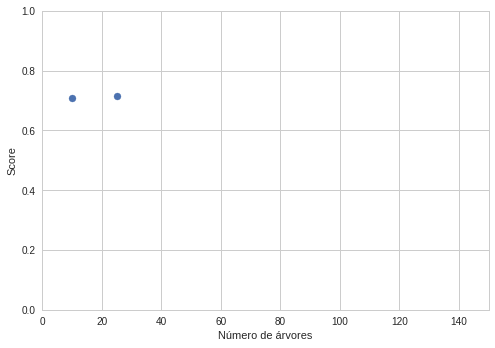

In [561]:
plt.style.use('seaborn-whitegrid')

def fold_i_of_k(dataset, i, k):
    n = len(dataset)
    return dataset[n*(i-1)//k:n*i//k]

  
def calculatePrecMacro(testFold, results):
  prec = {}
  
  for i, d in enumerate(possibleClasses):
    vn = vp = fn = fp = 0

    for i in range(len(testFold)):
        if testFold[i][-1] != results[i][0]:
            if results[i][0] == d:
                fp += 1
            else:
                fn += 1
        else:
            if results[i][0] == d:
                vp += 1
            else:
                vn += 1

    print ("vp: " + str(vp) + "  vn: " + str(vn) + " fp: " + str(fp) + " fn: " + str(fn))

    prec[d] = vp / float(vp + fp)

  prec_macro = sum(prec.values()) / len(prec)

  return prec_macro

def calculateAccuracyAndF1(testFold, results):
  incorrect = 0
  fp = fn = vp = vn = 0
  for i in range(len(testFold)):
      if testFold[i][-1] != results[i][0]:
          incorrect += 1 # For acurracy
          if results[i][0] == VALOR_NEGATIVO:
              fn += 1
          elif results[i][0] == VALOR_POSITIVO:
              fp += 1
      else:
          if results[i][0] == VALOR_NEGATIVO:
              vn += 1
          elif results[i][0] == VALOR_POSITIVO:
              vp += 1

  print ("vp: " + str(vp) + "  vn: " + str(vn) + " fp: " + str(fp) + " fn: " + str(fn))

  rev =  vp / float(vp + fn)
  prec = vp / float(vp + fp)

  f1 = 2 * (prec * rev / float(prec + rev))

  return (1 - (incorrect/float(len(testFold)))), f1

def main_random_forest(ntree):
  dataset_copy = copy.copy(dataset)
  np.random.shuffle(dataset_copy)
  
  outcomes = { d:[] for i,d in enumerate(possibleClasses)}
  
  for i in dataset_copy:
    outcomes[i[-1]].append(i)
  
  folds_by_class = {}
  for index, d in enumerate(possibleClasses):
    folds_by_class[d] = [fold_i_of_k(outcomes[d], i+1, KFOLDS) for i in range(KFOLDS)]
  
  folds = [np.concatenate(tuple(folds_by_class[d][i] for d in possibleClasses), axis=0) for i in range(KFOLDS)]
  
  accuracy = [0 for i in range(KFOLDS)]
  f1_score = [0 for i in range(KFOLDS)]
  prec_macro_score = [0 for i in range(KFOLDS)]

  print("KFOLDS = %d \t ntree = %s" % (KFOLDS, ntree))
  
  for i in range(KFOLDS):
      minlen = len(dataset)
      for v1 in folds_by_class.keys():
        for v2 in folds_by_class[v1]:
          minlen = min(minlen, len(v2))

      # Concatenate and remove outcome
      original_testing_fold = np.concatenate(tuple(folds_by_class[d][i][0:minlen-1] for d in possibleClasses), axis=0)
      testing_fold = np.delete(original_testing_fold, -1, axis=1)

      training_fold = None
      for j in range(KFOLDS):
          if (i != j):
              if training_fold is None:
                  training_fold = np.concatenate(tuple(folds_by_class[d][j][0:minlen-1] for d in possibleClasses), axis=0)
              else:
                  newarray = np.concatenate(tuple(folds_by_class[d][j][0:minlen-1] for d in possibleClasses), axis=0)
                  training_fold = np.concatenate((training_fold, newarray), axis=0)
                  
      testing_fold_list = testing_fold.tolist()

      forest = createForest(training_fold, ntree);

      fold_results = []
      for index, testfold in enumerate(testing_fold_list):
        results = []
        for tree in forest:
          answer = classify(tree, testfold)
          if answer != None:
            results.append(answer)
          
        fold_results.append([most_common(results)])
        #print("Votação majoritária: " + str(most_common(results)))
        #print("Esperado: " + str(original_testing_fold[index][allAttributes[EXPECTED_COLUMN]]) + "\n\n")
              
      if len(possibleClasses) <= 2:
        acc, f1 = calculateAccuracyAndF1(original_testing_fold, fold_results)
        accuracy[i] = acc
        f1_score[i] = f1
        print("FOLD #%d ->  acc:%f  f1:%f" % (i, acc, f1))
      else:
        precmacro = calculatePrecMacro(original_testing_fold, fold_results)
        prec_macro_score[i] = precmacro
        print("FOLD #%d ->  prec_macro:%f" % (i, precmacro))

  if len(possibleClasses) <= 2:
    accuracy_avg = np.average(accuracy)
    accuracy_std = np.std(accuracy)
    f1_avg = np.average(f1_score)
    f1_std = np.std(f1_score)
    print("Acurácia   -> \tMédia: %.2f\tDesvio Padrão: %.2f" % (accuracy_avg, accuracy_std))
    print("Escore F-1 -> \tMédia: %.2f\tDesvio Padrão: %.2f" % (f1_avg, f1_std))
    return [f1_avg, f1_std]
  
  else:
    precmacro_avg = np.average(prec_macro_score)
    precmacro_std = np.std(prec_macro_score)
    print("Escore prec_macro-> \tMédia: %.2f\tDesvio Padrão: %.2f" % (precmacro_avg, precmacro_std))
    return [precmacro_avg, precmacro_std]

ntrees_to_test = [10, 25, 50, 75, 100, 125]
score_results = [main_random_forest(i) for i in ntrees_to_test]
score_r_avg = np.array(score_results)[:,0]
score_r_std = np.array(score_results)[:,1]

print(score_r_avg)
print(score_r_std)

plt.xlim(0, 150)
plt.ylim(0, 1)
plt.xlabel("Número de árvores")
plt.ylabel("Score")
plt.scatter(ntrees_to_test, score_r_avg, marker='o');


